# Lecture 5: Generative models

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [2]:
(mnist_train,
 mnist_test) = [torchvision.datasets.MNIST(root='~/Library/CloudStorage/Box-Box/teaching/msds-534-fall-2024/code/data',
                      train=train,
                      download=True,
                      transform=torchvision.transforms.ToTensor())
                for train in [True, False]]

In [3]:
train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False)

In [4]:
# what does one data batch look like?
# fetch the next batch of data from the train_loader
# iter(train_loader) converts the train_loader into an iterator
# next(...) retrieves the next batch from the iterator
batch = next(iter(train_loader))

In [5]:
batch

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [6]:
batch[0].shape  # this is the image, dims are: B, C, H, W (gray image so C=1)

torch.Size([64, 1, 28, 28])

In [7]:
imgs = batch[0]

In [8]:
# note: when we input the data, it will need to be B, H * W
imgs = imgs.reshape(imgs.shape[0], 28*28)

In [9]:
imgs.shape # this shape will be what we input to the VAE

torch.Size([64, 784])

In [10]:
print(torch.min(imgs), torch.max(imgs)) # range of pixel values. 0 is white pixels, 1 is black pixels, in between are gray

tensor(0.) tensor(1.)


In [11]:
batch[1] # this is the label for each image

tensor([9, 8, 0, 3, 1, 1, 0, 2, 2, 7, 3, 9, 7, 3, 2, 4, 4, 0, 0, 7, 3, 3, 5, 8,
        3, 9, 4, 1, 2, 5, 1, 2, 2, 5, 0, 9, 9, 6, 5, 6, 7, 6, 7, 0, 1, 2, 7, 6,
        2, 1, 6, 8, 2, 3, 0, 5, 5, 3, 4, 0, 7, 9, 7, 8])

### Plot data examples

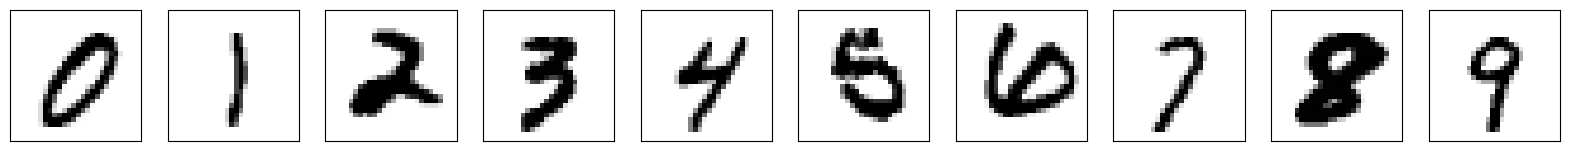

In [12]:
n_img = 10
num_cols = 5
num_rows = 2
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(n_img):

  # for each label, get an image from the test dataset with that label

  inds = torch.where(mnist_test.test_labels == i)[0].numpy()
  ind = np.random.choice(inds)

  x, label = mnist_test[ind]

  plt.subplot(num_rows, 2 * num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[0].detach().cpu().numpy(), cmap=plt.cm.binary)


### Define VAE class

In [13]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim, loss_type='mse'):
        super(VAE, self).__init__()
        self.loss_type = loss_type

        # define encoder and decoder functions in the init
        self.q_z = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                 nn.ReLU(),
                                 nn.Linear(hidden_dim, hidden_dim),
                                 nn.ReLU())

        self.z_mean = nn.Linear(hidden_dim, latent_dim)
        self.z_log_var = nn.Linear(hidden_dim, latent_dim)

        self.generator = nn.Sequential(nn.Linear(latent_dim, hidden_dim),
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, hidden_dim),
                                       nn.ReLU(),
                                       nn.Linear(hidden_dim, input_dim))

    def encode(self, x):
        q_z = self.q_z(x)
        z_mean = self.z_mean(q_z)
        z_log_var = self.z_log_var(q_z)
        return z_mean, z_log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mean + eps * std
        return sample

    def decode(self, z):
        x_reconstructed = self.generator(z)

        if self.loss_type == 'binary':
            x_reconstructed = F.sigmoid(x_reconstructed)

        return x_reconstructed
    
    def forward(self, x):
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        x_mean = self.decode(z)
        # f_theta(z^l) # one monte carlo sample
        return x_mean, z, z_mean, z_log_var

    def reconstruction_loss(self, x_pred, x):
        if self.loss_type == 'mse':
            loss = nn.MSELoss()
            reconstruction_loss = 0.5 * loss(x_pred, x)

        if self.loss_type == 'binary':
            reconstruction_loss = x * torch.log(x_pred + 1e-6) + \
                  (1-x) * torch.log(1 - x_pred + 1e-6)
            reconstruction_loss = -reconstruction_loss.sum(1).mean()

        return reconstruction_loss

    def vae_loss(self, x):

        x_mean, z, z_mean, z_log_var = self.forward(x)

        
        kld = 1 + z_log_var - z_mean.pow(2) - z_log_var.exp()
        kl_loss = -0.5 * torch.mean(kld)


        reconstruction_loss = self.reconstruction_loss(x_mean, x)

        return reconstruction_loss, kl_loss

In [14]:
input_dim = 28 * 28 # mnist pixels 28x28=784
hidden_dim = 300
latent_dim = 10 # we are compressing each image of 784 pixels to a 10 dim vector - we are compressing a lot of information

In [ ]:
model = VAE(input_dim, latent_dim, hidden_dim, loss_type='binary') # loss type = 'binary' because pixels are in [0, 1]
lr = 1e-3
epochs = 50

optimizer = optim.Adam(model.parameters(), lr=lr)

# set model to training mode
model.train()

for epoch in range(epochs):

    epoch_loss = 0
    epoch_recon = 0
    epoch_kl = 0

    for x_batch, y_batch in train_loader:

        x_batch = x_batch.reshape(x_batch.shape[0], 28*28)
        reconstruction_loss, kl_loss = model.vae_loss(x_batch)
        total_loss = reconstruction_loss + kl_loss

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += total_loss.item()
        epoch_recon += reconstruction_loss.item()
        epoch_kl += kl_loss.item()

    epoch_loss = epoch_loss / len(train_loader)
    epoch_recon = epoch_recon / len(train_loader)
    epoch_kl = epoch_kl / len(train_loader)

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{epoch_loss:.3}", 'recon loss:', f"{epoch_recon:.3}",
              'kld:', f"{epoch_kl:.3}")



In [13]:
# save model
torch.save(model.state_dict(), "vae_latent_" + str(latent_dim) + ".pt")

In [15]:
# load models
latent_dim = 10
model = VAE(input_dim, latent_dim, hidden_dim, loss_type='binary')

model.load_state_dict(torch.load("vae_latent_" + str(latent_dim) + ".pt"))

<All keys matched successfully>

### Plot reconstructions

- see how reconstructions change for models with different `latent_dim` 

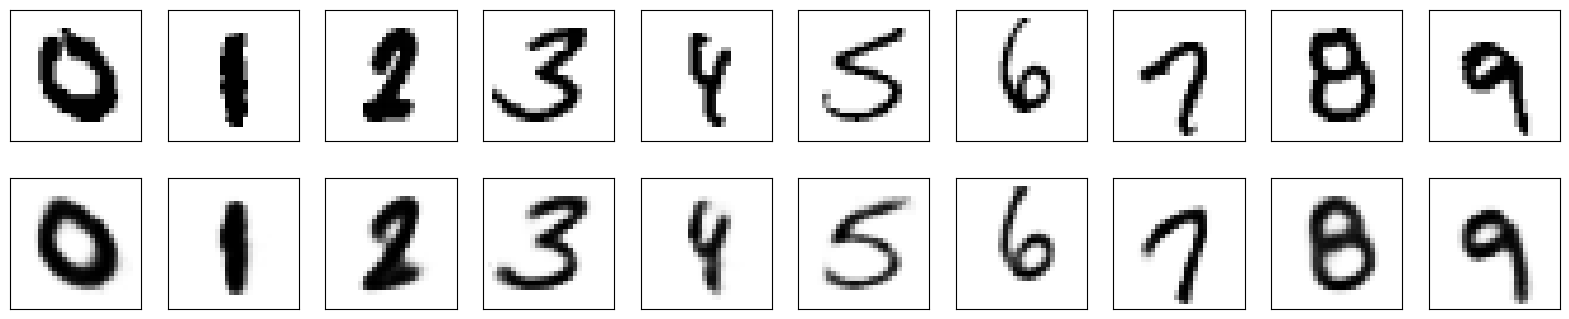

In [16]:
model.eval()

n_img = 10
num_cols = 5
num_rows = 2
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(n_img):

  # for each label, get an image from the test dataset with that label

  inds = torch.where(mnist_test.test_labels == i)[0].numpy()
  ind = np.random.choice(inds)

  x, label = mnist_test[ind]
  x_batch = x.reshape(x.shape[0], 28*28)

  x_mean, z, z_mean, z_log_var = model(x_batch)
  x_recon = x_mean.reshape((28,28))

  plt.subplot(num_rows, 2 * num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[0].detach().cpu().numpy(), cmap=plt.cm.binary)

  plt.subplot(num_rows, 2 * num_cols, (i + 1) + 2 * num_cols)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_recon.detach().cpu().numpy(), cmap=plt.cm.binary)


![VAE](bottleneck.jpg)

### Plot the 2-dimensional latent space

Before we had `latent_dim=10`. Now let's look at `latent_dim=2` (more compression)

In [17]:
# load models
latent_dim = 2
model = VAE(input_dim, latent_dim, hidden_dim, loss_type='binary')

model.load_state_dict(torch.load("vae_latent_" + str(latent_dim) + ".pt"))

<All keys matched successfully>

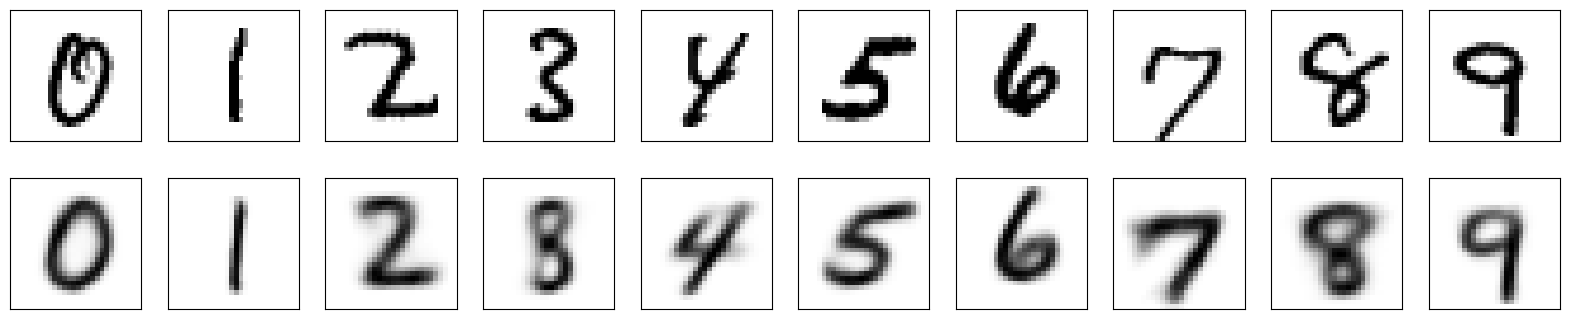

In [18]:
model.eval()

n_img = 10
num_cols = 5
num_rows = 2
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(n_img):

  # for each label, get an image from the test dataset with that label

  inds = torch.where(mnist_test.test_labels == i)[0].numpy()
  ind = np.random.choice(inds)

  x, label = mnist_test[ind]
  x_batch = x.reshape(x.shape[0], 28*28)

  x_mean, z, z_mean, z_log_var = model(x_batch)
  x_recon = x_mean.reshape((28,28))

  plt.subplot(num_rows, 2 * num_cols, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x[0].detach().cpu().numpy(), cmap=plt.cm.binary)

  plt.subplot(num_rows, 2 * num_cols, (i + 1) + 2 * num_cols)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_recon.detach().cpu().numpy(), cmap=plt.cm.binary)


In [19]:
labels = mnist_test.test_labels
labels = labels.numpy()
labels = labels.reshape(-1, 1)

In [20]:
x_test = mnist_test.data
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test.to(torch.float) 

In [21]:
z_test, _ = model.encode(x_test)
z_np = z_test.detach().numpy()

In [22]:
df = pd.DataFrame(z_np, columns = ['z' + str(i+1) for i in range(z_np.shape[1])])
df['label'] = labels
df['label'] = df['label'].astype('category')

<Axes: xlabel='z1', ylabel='z2'>

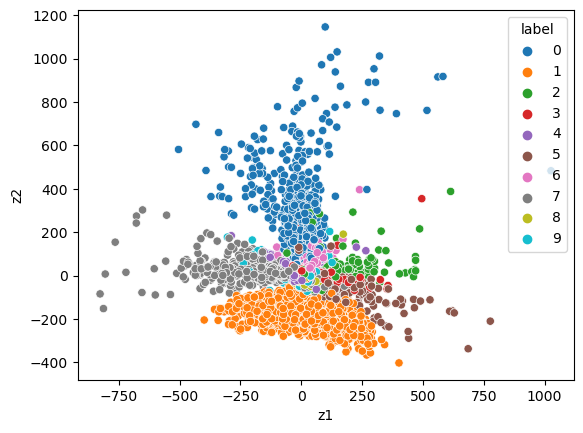

In [23]:
# Create a scatter plot with colored clusters
sns.scatterplot(x='z1', y='z2', hue='label', data=df)

### Compare with PCA

- PCA does linear dimension reduction (VAE does nonlinear dimension reduction)

(10000, 784)
shape of pca_reduced.shape =  (10000, 2)


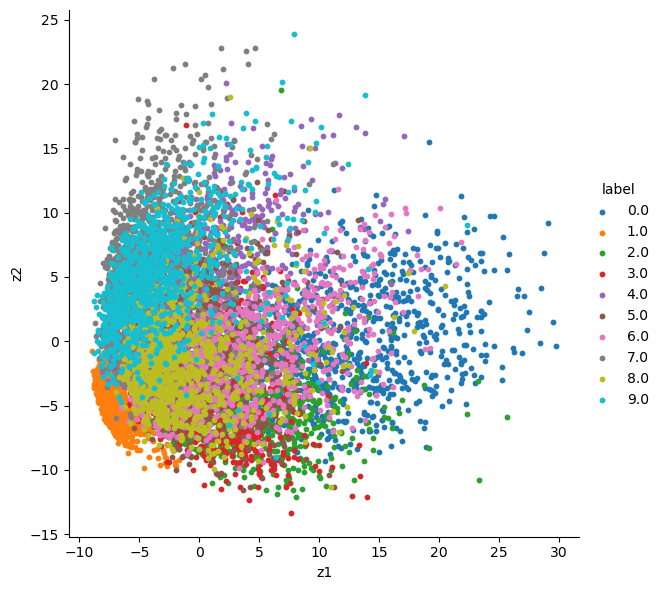

In [24]:
from sklearn.preprocessing import StandardScaler
x_test_std = StandardScaler().fit_transform(x_test)
print(x_test_std.shape)

labels = mnist_test.test_labels
labels = labels.numpy()
# labels = labels.reshape(-1, 1)

from sklearn import decomposition
pca = decomposition.PCA()

pca.n_components = 2
# select 2 components for 2-D visualization 
pca_data = pca.fit_transform(x_test_std)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

pca_data = np.vstack((pca_data.T, labels)).T
pca_df = pd.DataFrame(data=pca_data, columns=("z1", "z2", "label"))
sns.FacetGrid(pca_df, hue="label", height=6, aspect=1).map(plt.scatter, 'z1', 'z2', s=10).add_legend()
# sns.scatterplot(x='z1', y='z2', hue='label', data=pca_df)
plt.show()

### Plot latent traversals 

- How can we better understand what the dimensions of the VAE latent space correspond to?
- We can plot latent traversals for `latent_dim=10`
- We consider a range of `z` values and see what their corresponding reconstructed `x` image looks like

In [25]:
# load models
latent_dim = 10
model = VAE(input_dim, latent_dim, hidden_dim, loss_type='binary')

model.load_state_dict(torch.load("vae_latent_" + str(latent_dim) + ".pt"))

<All keys matched successfully>

In [26]:
# Create a grid of latent vectors for traversal
n_samples = 20
grid_x = np.linspace(-3, 3, n_samples)
grid_y = np.linspace(-3, 3, n_samples)
traversal_grid = torch.FloatTensor(n_samples, n_samples, 10)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = torch.FloatTensor([[xi, yi, 0, 0, 0, 0, 0, 0, 0, 0]])
        traversal_grid[j, i] = z_sample

In [27]:
# these are the range of x and y values we consider
print(grid_x)
print(grid_y)

[-3.         -2.68421053 -2.36842105 -2.05263158 -1.73684211 -1.42105263
 -1.10526316 -0.78947368 -0.47368421 -0.15789474  0.15789474  0.47368421
  0.78947368  1.10526316  1.42105263  1.73684211  2.05263158  2.36842105
  2.68421053  3.        ]
[-3.         -2.68421053 -2.36842105 -2.05263158 -1.73684211 -1.42105263
 -1.10526316 -0.78947368 -0.47368421 -0.15789474  0.15789474  0.47368421
  0.78947368  1.10526316  1.42105263  1.73684211  2.05263158  2.36842105
  2.68421053  3.        ]


In [28]:
# we vary each dimension while holding the other dimension fixed so we can interpret each dimension
traversal_grid[0, 0, :]

tensor([-3., -3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [29]:
traversal_grid[1, 0, :]

tensor([-3.0000, -2.6842,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])

In [30]:
# Generate images from the latent traversal grid
with torch.no_grad():
    traversal_grid = traversal_grid.view(-1, 10) # collapsing to 400 x 10
    generated_images = model.decode(traversal_grid).view(-1, 1, 28, 28) # B x C x H x W


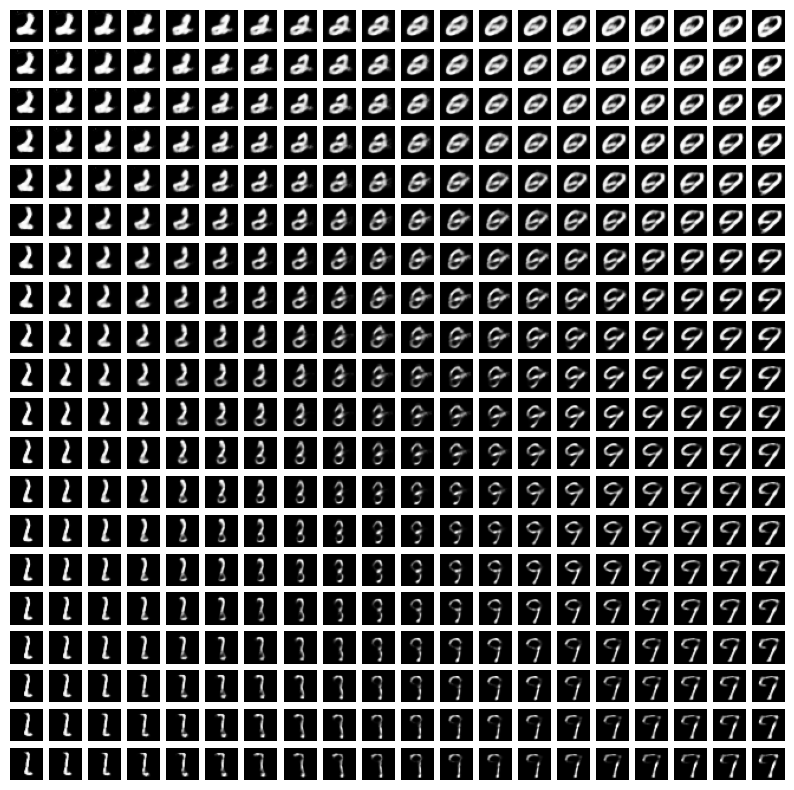

In [31]:
# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    for j in range(n_samples):
        plt.subplot(n_samples, n_samples, i * n_samples + j + 1)
        plt.imshow(generated_images[i * n_samples + j].squeeze().cpu().numpy(), cmap="gray")
        plt.axis('off')

plt.show()

# latent traversal plots

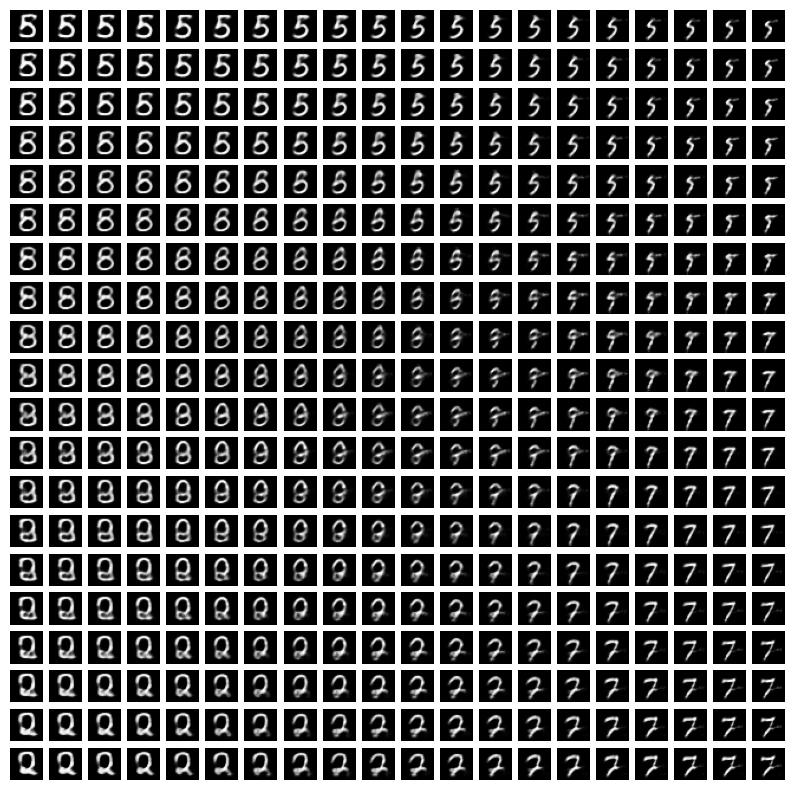

In [32]:
# try other verison
# Create a grid of latent vectors for traversal
n_samples = 20
grid_x = np.linspace(-3, 3, n_samples)
grid_y = np.linspace(-3, 3, n_samples)
traversal_grid = torch.FloatTensor(n_samples, n_samples, 10)

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = torch.FloatTensor([[0, 0, 0, xi, yi, 0, 0, 0, 0, 0]])
        traversal_grid[j, i] = z_sample

# Generate images from the latent traversal grid
with torch.no_grad():
    traversal_grid = traversal_grid.view(-1, 10) # collapsing to 400 x 10
    generated_images = model.decode(traversal_grid).view(-1, 1, 28, 28) # B x C x H x W

# Plot the generated images
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    for j in range(n_samples):
        plt.subplot(n_samples, n_samples, i * n_samples + j + 1)
        plt.imshow(generated_images[i * n_samples + j].squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')

plt.show()
